In [332]:
import joblib
import pickle

import time
import datetime
import numpy as np
import pandas as pd
from keras.src.saving import load_model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
from nltk import word_tokenize
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.src.utils import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef

from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [333]:
import warnings

warnings.filterwarnings('ignore')

In [334]:
device = torch.device("cpu")
device

device(type='cpu')

### Funktionen

#### Datenvorbereitung etc.

In [335]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [336]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [337]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [338]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [339]:
def vectorize_w2v(tweets, loaded_vectorizer, vector_size=300):
    x_tokenized = tweets.map(word_tokenize)

    def w2v_vector(x_tokenized, vector_size):
        vec = np.zeros(vector_size).reshape((1, vector_size))
        count = 0
        for word in x_tokenized:
            try:
                vec += loaded_vectorizer.wv[word].reshape((1, vector_size))
                count += 1
            except KeyError:

                continue
        if count != 0:
            vec /= count
        return vec

    tweets_w2v = np.zeros((len(x_tokenized), 300))
    for i in range(len(x_tokenized)):
        tweets_w2v[i, :] = w2v_vector(x_tokenized.iloc[i], 300)

    return tweets_w2v

In [340]:
def tokenize_and_vectorize_for_lstm(tokenizer, glove_embeddings, tweets, vector_size=200, max_seq_len=50):
    X_sequences = tokenizer.texts_to_sequences(tweets)
    X_padded = pad_sequences(X_sequences, padding='post', maxlen=max_seq_len)

    def get_glove_vectors(sequence, glove_embeddings, vector_size, max_seq_len):
        vectors = [glove_embeddings.get(tokenizer.index_word.get(idx, ''), np.zeros(vector_size)) for idx in sequence]

        # Padding sicherstellen
        if len(vectors) < max_seq_len:
            vectors.extend([np.zeros(vector_size)] * (max_seq_len - len(vectors)))
        else:
            vectors = vectors[:max_seq_len]

        return np.array(vectors, dtype=np.float32)

    X_vectors = np.array([get_glove_vectors(seq, glove_embeddings, vector_size, max_seq_len) for seq in X_padded],
                         dtype=np.float32)

    return X_vectors

#### Evaluationsfunktionen

In [341]:
def print_wordcloud(dataframe, tweet_col, label_col):
    dataset_0_text = " ".join(dataframe[dataframe[label_col] == 0][tweet_col].tolist())
    dataset_1_text = " ".join(dataframe[dataframe[label_col] == 1][tweet_col].tolist())

    plt.figure(figsize=(12, 6))

    # Subplot 1: Dataset 0
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(
        dataset_0_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0)", fontsize=14)

    # Subplot 2: Dataset 1
    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(
        dataset_1_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1)", fontsize=14)

    plt.tight_layout()
    plt.show()

##### Metriken

In [342]:
def get_predictions_bert(test_dataloader, model):
    predictions = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

        batches_completed += 1

    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions

In [343]:
def add_to_eval_df(model_name, y_prediction, y_true, sample_size, df, dataset_name, threshold):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    mcc = matthews_corrcoef(y_true, y_prediction)

    df.loc[len(df.index)] = [model_name, dataset_name, sample_size, threshold, accuracy, precision, recall, f1, mcc]

In [344]:
def eval_model_bert(tokenizer, model, model_name, labels, tweets, batch_size, data_size, df, dataset_name, threshold,
                    max_len=None):
    if max_len is None:
        max_len = get_max_len(tweets, tokenizer)
    dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=labels,
                             tweets_data=tweets)
    dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=dataset)
    predictions = get_predictions_bert(test_dataloader=dataloader, model=model)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [345]:
# geeignet für tf-idf bayes und ensemble
def eval_classic_model(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = (model.predict_proba(X_vectorized)[:, 1] >= threshold)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [346]:
def eval_model_svm(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = model.predict(X_vectorized)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [347]:
def eval_model_gru(tokenizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold, max_len):
    X_data = [str(x) for x in tweets]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)
    predictions = (model.predict(tweets_padded) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [348]:
def eval_model_lstm(tokenizer, vectorizer, model, labels, tweets, threshold, model_name, data_size, df, dataset_name):
    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=tweets,
        tokenizer=tokenizer
    )

    predictions = (model.predict(X_data_vectorized) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

##### Wahrscheinlichkeiten

In [349]:
def get_predictions_with_probabilities_bert(test_dataloader, model, threshold):
    predictions = []
    predictions_proba = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            pred_with_thresh = [1 if value[1] > threshold else 0 for value in output.logits.softmax(dim=-1).tolist()]
            pred_with_thresh = np.array(pred_with_thresh)

            predictions.extend(list(pred_with_thresh))
            predictions_proba.extend(output.logits.softmax(dim=-1).tolist())

        batches_completed += 1

    print("Prediction finished.")
    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions, predictions_proba

In [350]:
def add_to_detail_eval_df(dataframe, predictions, probabilities=None):
    if probabilities is not None:
        dataframe["zero_proba"] = pd.Series((v[0] for v in probabilities), index=dataframe.index)
        dataframe["one_proba"] = pd.Series((v[1] for v in probabilities), index=dataframe.index)
    else:
        dataframe["zero_proba"] = 0
        dataframe["one_proba"] = 0
    dataframe["pred"] = predictions

    return dataframe

In [351]:
def add_pred_and_probas_bert(model, tokenizer, data, label_name, tweet_name, batch_size, threshold):
    x_data = data[tweet_name].values
    y_data = data[label_name].values
    max_len = get_max_len(x_data, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=y_data,
                                  tweets_data=x_data)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)

    predictions, predictions_proba = get_predictions_with_probabilities_bert(test_dataloader=test_dataloader,
                                                                             model=model, threshold=threshold)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=predictions_proba)

In [352]:
def add_pred_and_probas(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    probabilities = model.predict_proba(X_vectorized)
    predictions = (probabilities[:, 1] >= threshold).astype(int)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [353]:
def add_pred_and_probas_svm(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    predictions = model.predict(X_vectorized)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions)

    return data

In [354]:
def add_pred_and_probas_gru(model, tokenizer, data, tweet_name, threshold, max_len):
    x_data = data[tweet_name].values

    X_data = [str(x) for x in x_data]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)

    probabilities = model.predict(tweets_padded)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [355]:
def add_pred_and_probas_lstm(model, tokenizer, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=x_data,
        tokenizer=tokenizer
    )

    probabilities = model.predict(X_data_vectorized)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

### 1. Modelle

In [356]:
MODELS_PATH = "../../webapp/backend/app/models"

#### 1.1 Bayes

In [357]:
nb_vectorizer = joblib.load(MODELS_PATH + "/nb/vectorizer_nb_tfidf.joblib")
nb_model = joblib.load(MODELS_PATH + "/nb/model_nb_tfidf_comp.joblib")
nb_modelname = "ComplementNB"

#### 1.2 Ensemble

In [358]:
ensemble_vectorizer = joblib.load(MODELS_PATH + "/ensemble/tfidf_vectorizer_for_brf.joblib")
ensemble_model = joblib.load(MODELS_PATH + "/ensemble/tfidf_balancedrandomforest.joblib")
ensemble_modelname = "BalancedRandomForest"

#### 1.3 SVM

In [359]:
svm_vectorizer = joblib.load(MODELS_PATH + "/svc/tfidf_vectorizer_svc.joblib")
svm_model = joblib.load(MODELS_PATH + "/svc/model_svc.joblib")
svm_modelname = "LinearSVC"

#### 1.4 RNN-GRU

In [360]:
max_len_gru = 40
gru_model = load_model(MODELS_PATH + "/gru/gru-model_mixed-dataset.keras")
with open(MODELS_PATH + "/gru/tokenizer_mixed-dataset.pkl", 'rb') as f:
    gru_tokenizer = pickle.load(f)
gru_modelname = "RNN-GRU"

#### 1.5 RNN-LSTM

In [361]:
lstm_model = load_model(MODELS_PATH + "/lstm/model_lstm_17.keras")
with open(MODELS_PATH + "/lstm/tokenizer_lstm.json", "r", encoding="utf-8") as f:
    tokenizer_data = f.read()
    lstm_tokenizer = tokenizer_from_json(tokenizer_data)
lstm_glove_embeddings = {}
with open(MODELS_PATH + "/lstm/glove.6B.200d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        lstm_glove_embeddings[word] = vector
lstm_modelname = "RNN-LSTM"

#### 1.6 BERT

In [362]:
PATH_BERT_TUNED = MODELS_PATH + "/bert/bert_mixed_imran"
bert_tokenizer = BertTokenizer.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_modelname = "bert_tuned_uncased"

#### 1.7 RoBERTa

In [363]:
PATH_ROBERTA_TUNED = MODELS_PATH + "/roberta/roberta_hate_mixed_cleaned"
roberta_tokenizer = AutoTokenizer.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_modelname = "roberta_hate_mixed_cleaned"

### 2. Daten

In [364]:
sample_size = 1000

#### 2.1 Mixed-Train (cleaned)

In [365]:
df_mixed_train_cleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_cleaned = df_mixed_train_cleaned[df_mixed_train_cleaned.tweet_cleaned.notna()]
df_mixed_train_cleaned = df_mixed_train_cleaned.sample(n=sample_size)

df_mixed_train_cleaned = df_mixed_train_cleaned[["label", "tweet_cleaned"]]
df_mixed_train_cleaned.head(1)

,label,tweet_cleaned
144704,0,ill fuck kid url


#### 2.2 Mixed-Train (cleaned-rnn)

In [366]:
df_mixed_train_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/train_cleaned_rnn.csv", index_col=0)
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[df_mixed_train_cleaned_rnn.tweet_cleaned.notna()]
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn.sample(n=sample_size)

df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[["label", "tweet_cleaned"]]
df_mixed_train_cleaned_rnn.head(1)

,label,tweet_cleaned
22710,0,i am with you


#### 2.3 Mixed-Train (uncleaned)

In [367]:
df_mixed_train_uncleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_uncleaned = df_mixed_train_uncleaned[df_mixed_train_uncleaned.tweet.notna()]
df_mixed_train_uncleaned = df_mixed_train_uncleaned.sample(n=sample_size)

df_mixed_train_uncleaned = df_mixed_train_uncleaned[["label", "tweet"]]
print(df_mixed_train_uncleaned.head(1))
print("Daten: \t", len(df_mixed_train_uncleaned))

        label                                              tweet
152496      0  @user but you were too busy being a raging bit...
Daten: 	 1000


#### 2.4 Mixed-Test (cleaned)

In [368]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]
df_mixed_test_cleaned = df_mixed_test_cleaned.sample(n=sample_size)

df_mixed_test_cleaned = df_mixed_test_cleaned[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned.head(1))
print("Daten: \t", len(df_mixed_test_cleaned))

        label                                      tweet_cleaned
116357      0  brooklyn load crap former officer michael sent...
Daten: 	 1000


#### 2.5 Mixed-Test (cleaned-RNN)

In [369]:
df_mixed_test_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/test_cleaned_rnn.csv", index_col=0)
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[df_mixed_test_cleaned_rnn.tweet_cleaned.notna()]
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn.sample(n=sample_size)

df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned_rnn.head(1))
print("Daten: \t", len(df_mixed_test_cleaned_rnn))

        label                                      tweet_cleaned
142702      0  asian white supremacists are the most insidiou...
Daten: 	 1000


#### 2.6 Mixed-Test (uncleaned)

In [370]:
df_mixed_test_uncleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_uncleaned = df_mixed_test_uncleaned[df_mixed_test_uncleaned.tweet.notna()]
df_mixed_test_uncleaned = df_mixed_test_uncleaned.sample(n=sample_size)

df_mixed_test_uncleaned = df_mixed_test_uncleaned[["label", "tweet", ]]
print(df_mixed_test_uncleaned.head(1))
print("Daten: \t", len(df_mixed_test_uncleaned))

        label                                              tweet
131984      0  While the Hindus were starry eyed with secular...
Daten: 	 1000


#### 2.7 Mixed-Test (manual-labeled, uncleaned, new)

In [503]:
df_mixed_manual_uncleaned_new = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[df_mixed_manual_uncleaned_new.tweet.notna()]

df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[["label_manual", "tweet", ]]
print(df_mixed_manual_uncleaned_new.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_new))

   label_manual                                  tweet
0             1  Post the shit or kill yourself faggot
Daten: 	 499


#### 2.8 Mixed-Test (manual-labeled, uncleaned, old)

In [505]:
df_mixed_manual_uncleaned_old = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[df_mixed_manual_uncleaned_old.label.notna()]

df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[["label", "tweet", ]]
print(df_mixed_manual_uncleaned_old.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_old))

   label                                  tweet
0    1.0  Post the shit or kill yourself faggot
Daten: 	 399


### 3. Allgemeine Evaluation - Metriken

In [373]:
def evaluate(label_col, tweet_col, data, dataset_name, threshold):
    evaluation_df = pd.DataFrame(
        columns=["model", "dataset_name", "sample_size", "threshold", "accuracy", "precision", "recall", "f1_score",
                 "mcc"])
    eval_classic_model(vectorizer=ensemble_vectorizer,
                       model=ensemble_model,
                       model_name=ensemble_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_classic_model(vectorizer=nb_vectorizer,
                       model=nb_model,
                       model_name=nb_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_model_svm(vectorizer=svm_vectorizer,
                   model=svm_model,
                   model_name=svm_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold="None")

    eval_model_lstm(tokenizer=lstm_tokenizer,
                    vectorizer=lstm_glove_embeddings,
                    model=lstm_model,
                    model_name=lstm_modelname,
                    labels=data[label_col],
                    tweets=data[tweet_col],
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_gru(tokenizer=gru_tokenizer,
                   model=gru_model,
                   model_name=gru_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold=threshold,
                   max_len=40)

    eval_model_bert(tokenizer=bert_tokenizer,
                    model=bert_model,
                    model_name=bert_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_bert(tokenizer=roberta_tokenizer,
                    model=roberta_model,
                    model_name=roberta_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    return evaluation_df

#### 3.1 Alle Datensätze - Schwellwert 0.5

##### 3.1.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [374]:
evaluation_mixed_train_cleaned = evaluate(label_col="label",
                                          tweet_col="tweet_cleaned",
                                          data=df_mixed_train_cleaned,
                                          dataset_name="df_mixed_train_cleaned",
                                          threshold=0.5,
                                          )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction start.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Total Prediction took 0:02:20 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [375]:
evaluation_mixed_train_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,1000,0.5,0.924,0.827381,0.747312,0.785311,0.740697
5,bert_tuned_uncased,df_mixed_train_cleaned,1000,0.5,0.908,0.752688,0.752688,0.752688,0.696177
0,BalancedRandomForest,df_mixed_train_cleaned,1000,0.5,0.885,0.641434,0.865591,0.736842,0.677568
4,RNN-GRU,df_mixed_train_cleaned,1000,0.5,0.840,0.546763,0.817204,0.655172,0.575316
2,LinearSVC,df_mixed_train_cleaned,1000,None,0.796,0.471154,0.790323,0.590361,0.493507
1,ComplementNB,df_mixed_train_cleaned,1000,0.5,0.780,0.449704,0.817204,0.580153,0.484259
3,RNN-LSTM,df_mixed_train_cleaned,1000,0.5,0.704,0.366505,0.811828,0.505017,0.388311


In [376]:
evaluation_mixed_train_cleaned.to_csv("evaluation_data/evaluation_mixed_train_cleaned.csv")

##### 3.1.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [377]:
evaluation_mixed_train_cleaned_rnn = evaluate(label_col="label",
                                              tweet_col="tweet_cleaned",
                                              data=df_mixed_train_cleaned_rnn,
                                              dataset_name="df_mixed_train_cleaned_rnn",
                                              threshold=0.5,
                                              )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [378]:
evaluation_mixed_train_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,1000,0.5,0.934,0.752896,0.989848,0.855263,0.826310
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,1000,0.5,0.849,0.615000,0.624365,0.619647,0.525479
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,1000,0.5,0.836,0.571429,0.670051,0.616822,0.515966
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,1000,0.5,0.821,0.535433,0.690355,0.603104,0.496512
2,LinearSVC,df_mixed_train_cleaned_rnn,1000,None,0.803,0.500000,0.725888,0.592133,0.482154
3,RNN-LSTM,df_mixed_train_cleaned_rnn,1000,0.5,0.741,0.419689,0.822335,0.555746,0.443933
1,ComplementNB,df_mixed_train_cleaned_rnn,1000,0.5,0.647,0.345850,0.888325,0.497866,0.378764


In [379]:
evaluation_mixed_train_cleaned_rnn.to_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn.csv")

##### 3.1.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [380]:
evaluation_mixed_train_uncleaned = evaluate(label_col="label",
                                            tweet_col="tweet",
                                            data=df_mixed_train_uncleaned,
                                            dataset_name="df_mixed_train_uncleaned",
                                            threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:20 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [381]:
evaluation_mixed_train_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,1000,0.5,0.904,0.684211,0.866667,0.764706,0.713227
5,bert_tuned_uncased,df_mixed_train_uncleaned,1000,0.5,0.821,0.502222,0.627778,0.558025,0.451911
2,LinearSVC,df_mixed_train_uncleaned,1000,None,0.798,0.460145,0.705556,0.557018,0.450220
0,BalancedRandomForest,df_mixed_train_uncleaned,1000,0.5,0.820,0.500000,0.622222,0.554455,0.447507
3,RNN-LSTM,df_mixed_train_uncleaned,1000,0.5,0.755,0.411444,0.838889,0.552102,0.458706
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,1000,0.5,0.813,0.485106,0.633333,0.549398,0.440161
1,ComplementNB,df_mixed_train_uncleaned,1000,0.5,0.681,0.340230,0.822222,0.481301,0.365949


In [382]:
evaluation_mixed_train_uncleaned.to_csv("evaluation_data/evaluation_mixed_train_uncleaned.csv")

##### 3.1.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [383]:
evaluation_mixed_test_cleaned = evaluate(label_col="label",
                                         tweet_col="tweet_cleaned",
                                         data=df_mixed_test_cleaned,
                                         dataset_name="df_mixed_test_cleaned",
                                         threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [384]:
evaluation_mixed_test_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,1000,0.5,0.844,0.594470,0.654822,0.623188,0.526093
0,BalancedRandomForest,df_mixed_test_cleaned,1000,0.5,0.810,0.512111,0.751269,0.609053,0.505111
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,1000,0.5,0.847,0.620879,0.573604,0.596306,0.502702
2,LinearSVC,df_mixed_test_cleaned,1000,None,0.752,0.433766,0.847716,0.573883,0.471001
4,RNN-GRU,df_mixed_test_cleaned,1000,0.5,0.766,0.445104,0.761421,0.561798,0.444734
1,ComplementNB,df_mixed_test_cleaned,1000,0.5,0.728,0.401055,0.771574,0.527778,0.400803
3,RNN-LSTM,df_mixed_test_cleaned,1000,0.5,0.662,0.353430,0.862944,0.501475,0.378633


In [385]:
evaluation_mixed_test_cleaned.to_csv("evaluation_data/evaluation_mixed_test_cleaned.csv")

##### 3.1.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [386]:
evaluation_mixed_test_cleaned_rnn = evaluate(label_col="label",
                                             tweet_col="tweet_cleaned",
                                             data=df_mixed_test_cleaned_rnn,
                                             dataset_name="df_mixed_test_cleaned_rnn",
                                             threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [387]:
evaluation_mixed_test_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,1000,0.5,0.807,0.524823,0.714976,0.605317,0.491615
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,1000,0.5,0.830,0.582960,0.628019,0.604651,0.497120
4,RNN-GRU,df_mixed_test_cleaned_rnn,1000,0.5,0.797,0.507042,0.695652,0.586558,0.466405
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,1000,0.5,0.777,0.471223,0.632850,0.540206,0.404672
3,RNN-LSTM,df_mixed_test_cleaned_rnn,1000,0.5,0.701,0.393023,0.816425,0.530612,0.398788
2,LinearSVC,df_mixed_test_cleaned_rnn,1000,None,0.754,0.437700,0.661836,0.526923,0.384343
1,ComplementNB,df_mixed_test_cleaned_rnn,1000,0.5,0.585,0.316254,0.864734,0.463131,0.307950


In [388]:
evaluation_mixed_test_cleaned_rnn.to_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn.csv")

##### 3.1.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [389]:
evaluation_mixed_test_uncleaned = evaluate(label_col="label",
                                           tweet_col="tweet",
                                           data=df_mixed_test_uncleaned,
                                           dataset_name="df_mixed_test_uncleaned",
                                           threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [390]:
evaluation_mixed_test_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_test_uncleaned,1000,0.5,0.802,0.496269,0.678571,0.573276,0.457684
5,bert_tuned_uncased,df_mixed_test_uncleaned,1000,0.5,0.799,0.490637,0.668367,0.565875,0.447955
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,1000,0.5,0.801,0.494253,0.658163,0.564551,0.446505
0,BalancedRandomForest,df_mixed_test_uncleaned,1000,0.5,0.775,0.446886,0.622449,0.520256,0.387289
3,RNN-LSTM,df_mixed_test_uncleaned,1000,0.5,0.705,0.378973,0.790816,0.512397,0.383441
2,LinearSVC,df_mixed_test_uncleaned,1000,None,0.739,0.402402,0.683673,0.506616,0.367382
1,ComplementNB,df_mixed_test_uncleaned,1000,0.5,0.599,0.309833,0.852041,0.454422,0.310067


In [391]:
evaluation_mixed_test_uncleaned.to_csv("evaluation_data/evaluation_mixed_test_uncleaned.csv")

##### 3.1.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [392]:
evaluation_mixed_manual_uncleaned_new = evaluate(label_col="label_manual",
                                                 tweet_col="tweet",
                                                 data=df_mixed_manual_uncleaned_new,
                                                 dataset_name="df_mixed_manual_uncleaned_new",
                                                 threshold=0.5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Total Prediction took 0:01:09 (h:mm:ss)
Prediction start.
Total Prediction took 0:01:09 (h:mm:ss)


In [393]:
evaluation_mixed_manual_uncleaned_new.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,499,0.5,0.889780,0.928251,0.841463,0.882729,0.782572
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,499,0.5,0.835671,0.841667,0.821138,0.831276,0.671361
2,LinearSVC,df_mixed_manual_uncleaned_new,499,None,0.825651,0.824490,0.821138,0.822811,0.651220
3,RNN-LSTM,df_mixed_manual_uncleaned_new,499,0.5,0.805611,0.754266,0.898374,0.820037,0.623275
4,RNN-GRU,df_mixed_manual_uncleaned_new,499,0.5,0.815631,0.856481,0.752033,0.800866,0.635193
1,ComplementNB,df_mixed_manual_uncleaned_new,499,0.5,0.757515,0.688822,0.926829,0.790295,0.549825
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,499,0.5,0.801603,0.841860,0.735772,0.785249,0.607158


In [394]:
evaluation_mixed_manual_uncleaned_new.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv")

##### 3.1.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [396]:
evaluation_mixed_manual_uncleaned_old = evaluate(label_col="label",
                                                 tweet_col="tweet",
                                                 data=df_mixed_manual_uncleaned_old,
                                                 dataset_name="df_mixed_manual_uncleaned_old",
                                                 threshold=0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Prediction start.
Total Prediction took 0:00:56 (h:mm:ss)
Prediction start.
Total Prediction took 0:00:56 (h:mm:ss)


In [397]:
evaluation_mixed_manual_uncleaned_old.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,399,0.5,0.847118,0.797814,0.858824,0.827195,0.691957
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,399,0.5,0.789474,0.715000,0.841176,0.772973,0.585759
4,RNN-GRU,df_mixed_manual_uncleaned_old,399,0.5,0.796992,0.748603,0.788235,0.767908,0.588338
2,LinearSVC,df_mixed_manual_uncleaned_old,399,None,0.766917,0.689655,0.823529,0.750670,0.542475
3,RNN-LSTM,df_mixed_manual_uncleaned_old,399,0.5,0.736842,0.632653,0.911765,0.746988,0.526936
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,399,0.5,0.764411,0.715909,0.741176,0.728324,0.520713
1,ComplementNB,df_mixed_manual_uncleaned_old,399,0.5,0.659148,0.561151,0.917647,0.696429,0.414067


In [398]:
evaluation_mixed_manual_uncleaned_old.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv")

#### 3.2 Alle Datensätze - Schwellwert 0.35

##### 3.2.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [399]:
evaluation_mixed_train_cleaned2 = evaluate(label_col="label",
                                           tweet_col="tweet_cleaned",
                                           data=df_mixed_train_cleaned,
                                           dataset_name="df_mixed_train_cleaned",
                                           threshold=0.35,
                                           )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [400]:
evaluation_mixed_train_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,1000,0.35,0.924,0.827381,0.747312,0.785311,0.740697
5,bert_tuned_uncased,df_mixed_train_cleaned,1000,0.35,0.908,0.752688,0.752688,0.752688,0.696177
4,RNN-GRU,df_mixed_train_cleaned,1000,0.35,0.822,0.512739,0.865591,0.644000,0.568113
0,BalancedRandomForest,df_mixed_train_cleaned,1000,0.35,0.781,0.456919,0.940860,0.615114,0.548564
2,LinearSVC,df_mixed_train_cleaned,1000,None,0.796,0.471154,0.790323,0.590361,0.493507
3,RNN-LSTM,df_mixed_train_cleaned,1000,0.35,0.668,0.341991,0.849462,0.487654,0.371502
1,ComplementNB,df_mixed_train_cleaned,1000,0.35,0.610,0.316547,0.946237,0.474394,0.375442


In [401]:
evaluation_mixed_train_cleaned2.to_csv("evaluation_data/evaluation_mixed_train_cleaned2.csv")

##### 3.2.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [402]:
evaluation_mixed_train_cleaned_rnn2 = evaluate(label_col="label",
                                               tweet_col="tweet_cleaned",
                                               data=df_mixed_train_cleaned_rnn,
                                               dataset_name="df_mixed_train_cleaned_rnn",
                                               threshold=0.35,
                                               )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [403]:
evaluation_mixed_train_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,1000,0.35,0.907,0.680556,0.994924,0.808247,0.773235
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,1000,0.35,0.849,0.615000,0.624365,0.619647,0.525479
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,1000,0.35,0.836,0.571429,0.670051,0.616822,0.515966
2,LinearSVC,df_mixed_train_cleaned_rnn,1000,None,0.803,0.500000,0.725888,0.592133,0.482154
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,1000,0.35,0.758,0.439024,0.822335,0.572438,0.465336
3,RNN-LSTM,df_mixed_train_cleaned_rnn,1000,0.35,0.688,0.374728,0.873096,0.524390,0.411597
1,ComplementNB,df_mixed_train_cleaned_rnn,1000,0.35,0.467,0.267956,0.984772,0.421281,0.288943


In [404]:
evaluation_mixed_train_cleaned_rnn2.to_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn2.csv")

##### 3.2.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [405]:
evaluation_mixed_train_uncleaned2 = evaluate(label_col="label",
                                             tweet_col="tweet",
                                             data=df_mixed_train_uncleaned,
                                             dataset_name="df_mixed_train_uncleaned",
                                             threshold=0.35)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [406]:
evaluation_mixed_train_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,1000,0.35,0.888,0.634921,0.888889,0.740741,0.687293
5,bert_tuned_uncased,df_mixed_train_uncleaned,1000,0.35,0.821,0.502222,0.627778,0.558025,0.451911
2,LinearSVC,df_mixed_train_uncleaned,1000,None,0.798,0.460145,0.705556,0.557018,0.450220
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,1000,0.35,0.813,0.485106,0.633333,0.549398,0.440161
0,BalancedRandomForest,df_mixed_train_uncleaned,1000,0.35,0.759,0.412104,0.794444,0.542694,0.440400
3,RNN-LSTM,df_mixed_train_uncleaned,1000,0.35,0.715,0.378190,0.905556,0.533552,0.448974
1,ComplementNB,df_mixed_train_uncleaned,1000,0.35,0.496,0.258209,0.961111,0.407059,0.290064


In [407]:
evaluation_mixed_train_uncleaned2.to_csv("evaluation_data/evaluation_mixed_train_uncleaned2.csv")

##### 3.2.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [408]:
evaluation_mixed_test_cleaned2 = evaluate(label_col="label",
                                          tweet_col="tweet_cleaned",
                                          data=df_mixed_test_cleaned,
                                          dataset_name="df_mixed_test_cleaned",
                                          threshold=0.35)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:16 (h:mm:ss)


In [409]:
evaluation_mixed_test_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,1000,0.35,0.844,0.594470,0.654822,0.623188,0.526093
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,1000,0.35,0.847,0.620879,0.573604,0.596306,0.502702
2,LinearSVC,df_mixed_test_cleaned,1000,None,0.752,0.433766,0.847716,0.573883,0.471001
4,RNN-GRU,df_mixed_test_cleaned,1000,0.35,0.743,0.423469,0.842640,0.563667,0.457204
0,BalancedRandomForest,df_mixed_test_cleaned,1000,0.35,0.697,0.383772,0.888325,0.535988,0.429936
3,RNN-LSTM,df_mixed_test_cleaned,1000,0.35,0.618,0.327103,0.888325,0.478142,0.350870
1,ComplementNB,df_mixed_test_cleaned,1000,0.35,0.522,0.280811,0.913706,0.429594,0.281574


In [410]:
evaluation_mixed_test_cleaned2.to_csv("evaluation_data/evaluation_mixed_test_cleaned2.csv")

##### 3.2.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [411]:
evaluation_mixed_test_cleaned_rnn2 = evaluate(label_col="label",
                                              tweet_col="tweet_cleaned",
                                              data=df_mixed_test_cleaned_rnn,
                                              dataset_name="df_mixed_test_cleaned_rnn",
                                              threshold=0.35)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [412]:
evaluation_mixed_test_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,1000,0.35,0.807,0.524823,0.714976,0.605317,0.491615
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,1000,0.35,0.830,0.582960,0.628019,0.604651,0.497120
4,RNN-GRU,df_mixed_test_cleaned_rnn,1000,0.35,0.771,0.466867,0.748792,0.575139,0.452180
2,LinearSVC,df_mixed_test_cleaned_rnn,1000,None,0.754,0.437700,0.661836,0.526923,0.384343
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,1000,0.35,0.698,0.382134,0.743961,0.504918,0.355152
3,RNN-LSTM,df_mixed_test_cleaned_rnn,1000,0.35,0.627,0.342205,0.869565,0.491132,0.351541
1,ComplementNB,df_mixed_test_cleaned_rnn,1000,0.35,0.384,0.246592,0.961353,0.392505,0.199824


In [413]:
evaluation_mixed_test_cleaned_rnn2.to_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn2.csv")

##### 3.2.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [415]:
evaluation_mixed_test_uncleaned2 = evaluate(label_col="label",
                                            tweet_col="tweet",
                                            data=df_mixed_test_uncleaned,
                                            dataset_name="df_mixed_test_uncleaned",
                                            threshold=0.35)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:16 (h:mm:ss)


In [416]:
evaluation_mixed_test_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_uncleaned,1000,0.35,0.799,0.490637,0.668367,0.565875,0.447955
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,1000,0.35,0.801,0.494253,0.658163,0.564551,0.446505
4,RNN-GRU,df_mixed_test_uncleaned,1000,0.35,0.766,0.440252,0.714286,0.544747,0.420148
0,BalancedRandomForest,df_mixed_test_uncleaned,1000,0.35,0.699,0.374101,0.795918,0.508972,0.379440
2,LinearSVC,df_mixed_test_uncleaned,1000,None,0.739,0.402402,0.683673,0.506616,0.367382
3,RNN-LSTM,df_mixed_test_uncleaned,1000,0.35,0.648,0.338843,0.836735,0.482353,0.348498
1,ComplementNB,df_mixed_test_uncleaned,1000,0.35,0.390,0.238636,0.964286,0.382591,0.209583


In [417]:
evaluation_mixed_test_uncleaned2.to_csv("evaluation_data/evaluation_mixed_test_uncleaned2.csv")

##### 3.2.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [418]:
evaluation_mixed_manual_uncleaned_new2 = evaluate(label_col="label_manual",
                                                  tweet_col="tweet",
                                                  data=df_mixed_manual_uncleaned_new,
                                                  dataset_name="df_mixed_manual_uncleaned_new",
                                                  threshold=0.35)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:01:08 (h:mm:ss)
Prediction start.
Total Prediction took 0:01:08 (h:mm:ss)


In [419]:
evaluation_mixed_manual_uncleaned_new2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,499,0.35,0.889780,0.928251,0.841463,0.882729,0.782572
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,499,0.35,0.835671,0.841667,0.821138,0.831276,0.671361
2,LinearSVC,df_mixed_manual_uncleaned_new,499,None,0.825651,0.824490,0.821138,0.822811,0.651220
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,499,0.35,0.811623,0.781481,0.857724,0.817829,0.626579
3,RNN-LSTM,df_mixed_manual_uncleaned_new,499,0.35,0.775551,0.706790,0.930894,0.803509,0.581892
4,RNN-GRU,df_mixed_manual_uncleaned_new,499,0.35,0.793587,0.806867,0.764228,0.784969,0.587591
1,ComplementNB,df_mixed_manual_uncleaned_new,499,0.35,0.657315,0.590799,0.991870,0.740516,0.428741


In [420]:
evaluation_mixed_manual_uncleaned_new2.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new2.csv")

##### 3.2.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [422]:
evaluation_mixed_manual_uncleaned_old2 = evaluate(label_col="label",
                                                  tweet_col="tweet",
                                                  data=df_mixed_manual_uncleaned_old,
                                                  dataset_name="df_mixed_manual_uncleaned_old",
                                                  threshold=0.35)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Prediction start.
Total Prediction took 0:00:55 (h:mm:ss)
Prediction start.
Total Prediction took 0:00:55 (h:mm:ss)


In [423]:
evaluation_mixed_manual_uncleaned_old2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,399,0.35,0.847118,0.797814,0.858824,0.827195,0.691957
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,399,0.35,0.789474,0.715000,0.841176,0.772973,0.585759
4,RNN-GRU,df_mixed_manual_uncleaned_old,399,0.35,0.789474,0.723958,0.817647,0.767956,0.580172
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,399,0.35,0.756892,0.663677,0.870588,0.753181,0.540873
2,LinearSVC,df_mixed_manual_uncleaned_old,399,None,0.766917,0.689655,0.823529,0.750670,0.542475
3,RNN-LSTM,df_mixed_manual_uncleaned_old,399,0.35,0.701754,0.595506,0.935294,0.727689,0.487323
1,ComplementNB,df_mixed_manual_uncleaned_old,399,0.35,0.568922,0.497041,0.988235,0.661417,0.337860


In [424]:
evaluation_mixed_manual_uncleaned_old2.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old2.csv")

#### Gesamtvergleich aller Datensätze und Schwellwerte

In [425]:
df_list = [
    evaluation_mixed_train_cleaned,
    evaluation_mixed_train_cleaned_rnn,
    evaluation_mixed_train_uncleaned,
    evaluation_mixed_test_cleaned,
    evaluation_mixed_test_cleaned_rnn,
    evaluation_mixed_test_uncleaned,
    evaluation_mixed_manual_uncleaned_new,
    evaluation_mixed_manual_uncleaned_old,

    evaluation_mixed_train_cleaned2,
    evaluation_mixed_train_cleaned_rnn2,
    evaluation_mixed_train_uncleaned2,
    evaluation_mixed_test_cleaned2,
    evaluation_mixed_test_cleaned_rnn2,
    evaluation_mixed_test_uncleaned2,
    evaluation_mixed_manual_uncleaned_new2,
    evaluation_mixed_manual_uncleaned_old2]

all_eval_dfs = pd.concat(df_list, axis=0)

In [426]:
all_eval_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,499,0.5,0.889780,0.928251,0.841463,0.882729,0.782572
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,499,0.35,0.889780,0.928251,0.841463,0.882729,0.782572
4,RNN-GRU,df_mixed_train_cleaned_rnn,1000,0.5,0.934000,0.752896,0.989848,0.855263,0.826310
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,499,0.5,0.835671,0.841667,0.821138,0.831276,0.671361
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,499,0.35,0.835671,0.841667,0.821138,0.831276,0.671361
...,...,...,...,...,...,...,...,...,...
1,ComplementNB,df_mixed_test_cleaned,1000,0.35,0.522000,0.280811,0.913706,0.429594,0.281574
1,ComplementNB,df_mixed_train_cleaned_rnn,1000,0.35,0.467000,0.267956,0.984772,0.421281,0.288943
1,ComplementNB,df_mixed_train_uncleaned,1000,0.35,0.496000,0.258209,0.961111,0.407059,0.290064
1,ComplementNB,df_mixed_test_cleaned_rnn,1000,0.35,0.384000,0.246592,0.961353,0.392505,0.199824


In [427]:
all_eval_dfs.to_csv("evaluation_data/all_eval_dfs.csv")

#### Fazit (vorläufig auf 1k Daten je Datensatz)
- Unterschied zwischen cleaned vs. uncleaned:
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
- Beste Modelle

### 4. Detaillierte Evaluation - Tweetbetrachtung

Fragen:
- gibt es Tweets, die von keinem Modell korrekt klassifiziert werden können? bzw. nur von wenigen? was haben diese Tweets gemeinsam?
- gibt es Tweets, die von allen Modellen korrekt klassifiziert werden können? bzw. von vielen? was haben diese Tweets gemeinsam?
-


In [444]:
def create_false_tweet_df(tweet_col, label_col, original_df, threshold):
    merged_false = original_df.copy()

    add_pred_and_probas(model=ensemble_model,
                        vectorizer=ensemble_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_ens',
                                 'one_proba': '1_ens',
                                 'pred': 'pred_ens'}, inplace=True)

    add_pred_and_probas(model=nb_model,
                        vectorizer=nb_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_nb',
                                 'one_proba': '1_nb',
                                 'pred': 'pred_nb'}, inplace=True)

    add_pred_and_probas_svm(model=svm_model,
                            vectorizer=svm_vectorizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_svm',
                                 'one_proba': '1_svm',
                                 'pred': 'pred_svm'}, inplace=True)

    add_pred_and_probas_lstm(model=lstm_model,
                             tokenizer=lstm_tokenizer,
                             vectorizer=lstm_glove_embeddings,
                             data=merged_false,
                             tweet_name=tweet_col,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_lstm',
                                 'one_proba': '1_lstm',
                                 'pred': 'pred_lstm'}, inplace=True)

    add_pred_and_probas_gru(model=gru_model,
                            tokenizer=gru_tokenizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold,
                            max_len=40)
    merged_false.rename(columns={'zero_proba': '0_gru',
                                 'one_proba': '1_gru',
                                 'pred': 'pred_gru'}, inplace=True)

    add_pred_and_probas_bert(model=bert_model,
                             tokenizer=bert_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_bert',
                                 'one_proba': '1_bert',
                                 'pred': 'pred_bert'}, inplace=True)

    add_pred_and_probas_bert(model=roberta_model,
                             tokenizer=roberta_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_rob',
                                 'one_proba': '1_rob',
                                 'pred': 'pred_rob'}, inplace=True)

    return merged_false

In [481]:
def get_all_false_merged(merged_false, label_col):
    all_false_merged = merged_false[
        (merged_false.pred_ens != merged_false[label_col]) &
        (merged_false.pred_nb != merged_false[label_col]) &
        (merged_false.pred_svm != merged_false[label_col]) &
        (merged_false.pred_gru != merged_false[label_col]) &
        (merged_false.pred_lstm != merged_false[label_col]) &
        (merged_false.pred_bert != merged_false[label_col]) &
        (merged_false.pred_rob != merged_false[label_col])]

    print("Anzahl falsch vorhergesagter Tweets (von allen Modelle):", len(all_false_merged), "/", len(merged_false) , "| Anteil: ", round((len(all_false_merged) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(all_false_merged[all_false_merged[label_col] == 0]))
    print("-- davon Label 1:", len(all_false_merged[all_false_merged[label_col] == 1]))

    return all_false_merged

In [497]:
def get_num_of_false(df, label_col, model_pred_col):
    return len(df[((df[label_col] == 0) & (df[model_pred_col] == 1)) | ((df[label_col] == 1) & (df[model_pred_col] == 0))])

In [498]:
def get_mostly_false_merged(merged_false, label_col):
    merged_false["preds"] = merged_false.pred_ens.values + \
                           merged_false.pred_nb.values + \
                           merged_false.pred_svm.values + \
                           merged_false.pred_gru.values + \
                           merged_false.pred_lstm.values + \
                           merged_false.pred_bert.values + \
                           merged_false.pred_rob.values
    mostly_false_merge = merged_false[((merged_false[label_col] == 0) & (merged_false.preds >= 4)) | (
                (merged_false[label_col] == 1) & (merged_false.preds <= 4))]

    print("Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch):", len(mostly_false_merge), "/", len(merged_false) , "| Anteil: ", round((len(mostly_false_merge) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(mostly_false_merge[mostly_false_merge[label_col] == 0]))
    print("-- davon Label 1:", len(mostly_false_merge[mostly_false_merge[label_col] == 1]))

    print("Modelle:")
    print("-- Ensemble: \t", get_num_of_false(mostly_false_merge, label_col, "pred_ens"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_ens") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- NB: \t\t\t", get_num_of_false(mostly_false_merge, label_col, "pred_nb"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_nb") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- SVM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_svm"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_svm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- GRU: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_gru"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_gru") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- LSTM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_lstm"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_lstm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- BERT: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_bert"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_bert") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- ROBERTA: \t", get_num_of_false(mostly_false_merge, label_col, "pred_rob"), "/", len(mostly_false_merge), " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_rob") / len(mostly_false_merge)) * 100, 2), "%")

    return mostly_false_merge

#### 4.1 manuell gelabelte Tweets - Schwellwert 0.5

In [431]:
merged_false_manual1 = create_false_tweet_df(tweet_col="tweet", label_col="label_manual", original_df=df_mixed_manual_uncleaned_new,
                                             threshold=0.5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Prediction finished.
Total Prediction took 0:01:09 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:01:09 (h:mm:ss)


In [432]:
merged_false_manual1

,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
0,1,Post the shit or kill yourself faggot,0.06,0.94,1,0.104995,0.895005,1,0,0,...,1,0.011137,0.988863,1,0.180920,0.819080,1,0.192266,0.807734,1
2,1,i hate jews so much i wish the holocaust actua...,0.16,0.84,1,0.273041,0.726959,1,0,0,...,1,0.195016,0.804984,1,0.512623,0.487377,0,0.023317,0.976683,1
3,1,Poor kid would have been better off with his h...,0.48,0.52,1,0.343098,0.656902,1,0,0,...,1,0.036294,0.963706,1,0.157057,0.842943,1,0.221822,0.778178,1
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,1,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,You want genocide? Cause this is how genocide ...,0.61,0.39,0,0.319353,0.680647,1,0,0,...,1,0.306345,0.693655,1,0.525672,0.474328,0,0.667509,0.332491,0
95,0,The black girl is gorgeous.,0.83,0.17,0,0.466069,0.533931,1,0,0,...,0,0.999834,0.000166,0,0.951984,0.048016,0,0.999379,0.000621,0
96,0,God help us Africans have mercy on us in the n...,0.95,0.05,0,0.462962,0.537038,1,0,0,...,0,0.996012,0.003988,0,0.994697,0.005303,0,0.999194,0.000806,0
97,0,"India not only exporting goods and services, A...",0.73,0.27,0,0.694790,0.305210,0,0,0,...,0,0.985596,0.014404,0,0.994159,0.005841,0,0.999075,0.000925,0


In [483]:
all_false_merged_manual1 = get_all_false_merged(merged_false_manual1, label_col="label_manual")
all_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 6 / 499 | Anteil:  1.2 %
-- davon Label 0: 4
-- davon Label 1: 2


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,6
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,6
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,6
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,6
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0,0


In [499]:
mostly_false_merged_manual1 = get_mostly_false_merged(merged_false_manual1, label_col="label_manual")
mostly_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 80 / 499 | Anteil:  16.03 %
-- davon Label 0: 35
-- davon Label 1: 45
Modelle:
-- Ensemble: 	 68 / 80  -  85.0 %
-- NB: 			 45 / 80  -  56.25 %
-- SVM: 		 58 / 80  -  72.5 %
-- GRU: 		 53 / 80  -  66.25 %
-- LSTM: 		 58 / 80  -  72.5 %
-- BERT: 		 53 / 80  -  66.25 %
-- ROBERTA: 	 34 / 80  -  42.5 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1,3
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
21,0,unironic incel parties will start to form. no ...,0.75,0.25,0,0.556272,0.443728,0,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241194,0.758806,1,0.571151,0.428849,0,0.606780,0.393220,0,4
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,0,0.932846,0.067154,0,5


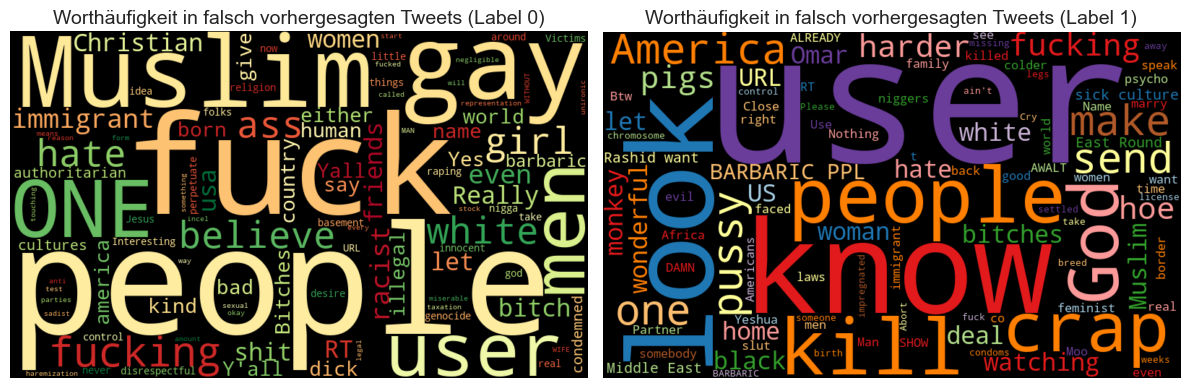

In [435]:
print_wordcloud(mostly_false_merged_manual1, tweet_col="tweet", label_col="label_manual")

#### 4.2 manuell gelabelte Tweets - Schwellwert 0.35

In [436]:
merged_false_manual2 = create_false_tweet_df(tweet_col="tweet", label_col="label_manual", original_df=df_mixed_manual_uncleaned_new,
                                             threshold=0.35)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Prediction finished.
Total Prediction took 0:01:09 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:01:09 (h:mm:ss)


In [437]:
merged_false_manual2

,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
0,1,Post the shit or kill yourself faggot,0.06,0.94,1,0.104995,0.895005,1,0,0,...,1,0.011137,0.988863,1,0.180920,0.819080,1,0.192266,0.807734,1
2,1,i hate jews so much i wish the holocaust actua...,0.16,0.84,1,0.273041,0.726959,1,0,0,...,1,0.195016,0.804984,1,0.512623,0.487377,1,0.023317,0.976683,1
3,1,Poor kid would have been better off with his h...,0.48,0.52,1,0.343098,0.656902,1,0,0,...,1,0.036294,0.963706,1,0.157057,0.842943,1,0.221822,0.778178,1
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,1,0.527259,0.472741,1,0,0,...,1,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,You want genocide? Cause this is how genocide ...,0.61,0.39,1,0.319353,0.680647,1,0,0,...,1,0.306345,0.693655,1,0.525672,0.474328,1,0.667509,0.332491,0
95,0,The black girl is gorgeous.,0.83,0.17,0,0.466069,0.533931,1,0,0,...,0,0.999834,0.000166,0,0.951984,0.048016,0,0.999379,0.000621,0
96,0,God help us Africans have mercy on us in the n...,0.95,0.05,0,0.462962,0.537038,1,0,0,...,0,0.996012,0.003988,0,0.994697,0.005303,0,0.999194,0.000806,0
97,0,"India not only exporting goods and services, A...",0.73,0.27,0,0.694790,0.305210,0,0,0,...,0,0.985596,0.014404,0,0.994159,0.005841,0,0.999075,0.000925,0


In [493]:
all_false_merged_manual2 = get_all_false_merged(merged_false_manual2, label_col="label_manual")
all_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 6 / 499 | Anteil:  1.2 %
-- davon Label 0: 6
-- davon Label 1: 0


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
66,0,RT @user: We Muslims have no military honour w...,0.46,0.54,1,0.214399,0.785601,1,0,0,...,0.006515,0.993485,1,0.596255,0.403745,1,0.008101,0.991899,1,7
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,7
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,7
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,7
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,7
74,0,RT @user: Wat type of bitch ass nigga rape a i...,0.38,0.62,1,0.450220,0.549780,1,0,0,...,0.505137,0.494863,1,0.359640,0.640360,1,0.085985,0.914015,1,7


In [500]:
mostly_false_merged_manual2 = get_mostly_false_merged(merged_false_manual2, label_col="label_manual")
mostly_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 83 / 499 | Anteil:  16.63 %
-- davon Label 0: 49
-- davon Label 1: 34
Modelle:
-- Ensemble: 	 65 / 83  -  78.31 %
-- NB: 			 51 / 83  -  61.45 %
-- SVM: 		 56 / 83  -  67.47 %
-- GRU: 		 57 / 83  -  68.67 %
-- LSTM: 		 62 / 83  -  74.7 %
-- BERT: 		 58 / 83  -  69.88 %
-- ROBERTA: 	 35 / 83  -  42.17 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,1,0,0,...,0.821766,0.178234,0,0.565452,0.434548,1,0.990371,0.009629,0,2
16,0,illegal immigrants =/= legal immigrants. in ev...,0.59,0.41,1,0.398594,0.601406,1,0,0,...,0.497590,0.502410,1,0.780791,0.219209,0,0.975723,0.024277,0,4
21,0,unironic incel parties will start to form. no ...,0.75,0.25,0,0.556272,0.443728,1,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241194,0.758806,1,0.571151,0.428849,1,0.606780,0.393220,1,6
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,1,0.932846,0.067154,0,6


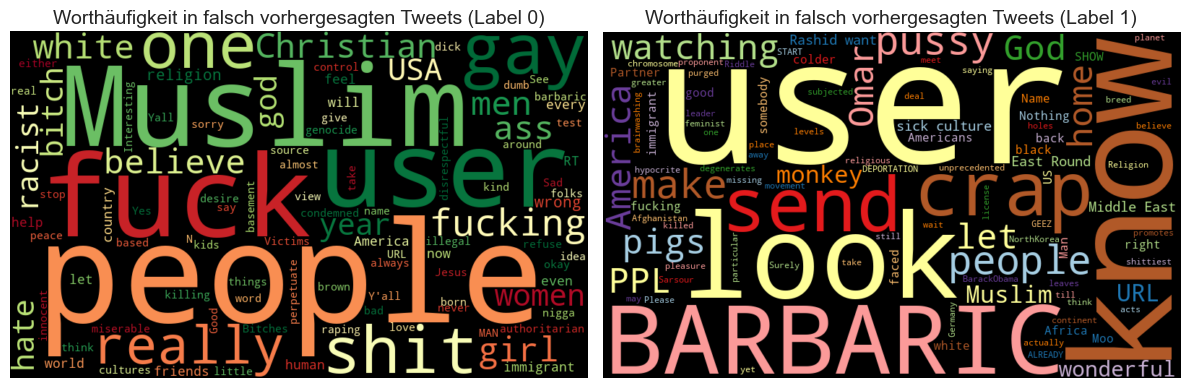

In [440]:
print_wordcloud(mostly_false_merged_manual2, tweet_col="tweet", label_col="label_manual")

#### 4.3 Mixed-Test cleaned - Schwellwert 0.5

In [441]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]

In [446]:
merged_false_tweet_cleaned1 = create_false_tweet_df(tweet_col="tweet_cleaned", label_col="label", original_df=df_mixed_test_cleaned,
                                                    threshold=0.5)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
Prediction start.
Prediction finished.
Total Prediction took 1:14:34 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 1:13:05 (h:mm:ss)


In [447]:
merged_false_tweet_cleaned1

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis,0_ens,1_ens,pred_ens,0_nb,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
8886,0,@user #cinemaaawards final rehearsals!! geari...,final gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN,0.75,0.25,0,0.836110,...,0,0.999995,0.000005,0,0.998820,0.001180,0,0.999381,0.000619,0
27613,0,this was amazing. the weather was not. #musica...,amazing weather musical london weekend …,0,"['#musical', '#london', '#matilda', '#westend'...",NaN,1.00,0.00,0,0.991430,...,0,0.999929,0.000071,0,0.998384,0.001616,0,0.999394,0.000606,0
18952,0,child attacked by alligator at walt disney wor...,child attack alligator disney world,0,['#waltdisneyworld'],NaN,0.81,0.19,0,0.825607,...,0,0.924563,0.075437,0,0.985559,0.014441,0,0.999216,0.000784,0
12485,0,me rn cause school is over soon,right cause school soon,0,[],NaN,0.70,0.30,0,0.592160,...,0,0.995754,0.004246,0,0.917947,0.082052,0,0.996966,0.003034,0
5879,0,is it #good to #sleep when ? #good #sleep,good sleep good sleep,0,"['#good', '#sleep', '#good', '#sleep']",NaN,0.83,0.17,0,0.649481,...,0,0.999758,0.000242,0,0.996236,0.003764,0,0.997868,0.002132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176360,0,Even liberals are humiliated by Charlie Rangel...,even liberal humiliate charlie claim gop back ...,0,['#8217'],NaN,0.69,0.31,0,0.548318,...,1,0.896264,0.103736,0,0.274048,0.725952,1,0.904447,0.095553,0
176366,0,@user photoshop my nig,photoshop nig,1,[],NaN,0.71,0.29,0,0.363628,...,1,0.990894,0.009106,0,0.943315,0.056685,0,0.976689,0.023311,0
176384,0,And mad hoes you can ask Beavis I get nothing ...,mad hoe ask beavis get nothing butthead,0,[],NaN,0.78,0.22,0,0.473839,...,1,0.998860,0.001140,0,0.350978,0.649022,1,0.997482,0.002518,0
176385,0,Because child concentration camps were not bad...,child concentration camp bad enough trump admi...,0,[],NaN,0.64,0.36,0,0.624282,...,0,0.887528,0.112472,0,0.927335,0.072665,0,0.981390,0.018610,0


In [502]:
all_false_merged_tweet_cleaned1 = get_all_false_merged(merged_false_tweet_cleaned1, label_col="label")
all_false_merged_tweet_cleaned1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 1496 / 32466 | Anteil:  4.61 %
-- davon Label 0: 1062
-- davon Label 1: 434


,label,tweet,tweet_cleaned,user_handle,hashtags,emojis,0_ens,1_ens,pred_ens,0_nb,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,1,[],NaN,0.70,0.30,0,0.572453,...,0.818643,0.181357,0,0.990094,0.009906,0,0.948021,0.051978,0,0
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,1,[],NaN,0.83,0.17,0,0.680407,...,0.961663,0.038337,0,0.957003,0.042997,0,0.995046,0.004954,0,0
17424,1,@user #freedownload a peek of #nyc here: the...,peek nyc come back holy,1,"['#freedownload', '#nyc']",NaN,0.88,0.12,0,0.515980,...,0.999588,0.000412,0,0.997054,0.002946,0,0.999180,0.000820,0,0
5087,1,""" in the workplace &amp; family responsibilit...",""" workplace family responsibility add pressure...",0,[],NaN,0.92,0.08,0,0.713795,...,0.997584,0.002416,0,0.794114,0.205886,0,0.999021,0.000979,0,0
21727,1,note: i was just able to pop this zit on my ne...,note able pop neck day day …,0,[],NaN,0.92,0.08,0,0.812397,...,0.994909,0.005091,0,0.998480,0.001520,0,0.999331,0.000669,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175707,0,Drown in your hypocrisy. Not once have you sho...,drown hypocrisy show empathy woman provide sou...,0,[],NaN,0.22,0.78,1,0.357373,...,0.466319,0.533681,1,0.338639,0.661361,1,0.133942,0.866058,1,7
175755,0,@user @user @user y'all some pussy ass niggas,pussy ass niggas,3,[],NaN,0.31,0.69,1,0.255930,...,0.292038,0.707962,1,0.242580,0.757420,1,0.092577,0.907423,1,7
176221,0,"Well, women deserve to be murdered. Incels sho...",well woman deserve murder incel never conseque...,0,[],NaN,0.17,0.83,1,0.201791,...,0.168841,0.831159,1,0.283943,0.716057,1,0.425188,0.574812,1,7
176224,1,"Another subreddit, same outcome. You are a bea...",another subreddit outcome beautiful woman need...,0,[],NaN,0.81,0.19,0,0.670378,...,0.999822,0.000178,0,0.997102,0.002898,0,0.999110,0.000890,0,0


In [501]:
mostly_false_merged_tweet_cleaned1 = get_mostly_false_merged(merged_false_tweet_cleaned1, label_col="label")
mostly_false_merged_tweet_cleaned1

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 7695 / 32466 | Anteil:  23.7 %
-- davon Label 0: 5243
-- davon Label 1: 2452
Modelle:
-- Ensemble: 	 5954 / 7695  -  77.37 %
-- NB: 			 6133 / 7695  -  79.7 %
-- SVM: 		 6408 / 7695  -  83.27 %
-- GRU: 		 5653 / 7695  -  73.46 %
-- LSTM: 		 6056 / 7695  -  78.7 %
-- BERT: 		 4937 / 7695  -  64.16 %
-- ROBERTA: 	 4308 / 7695  -  55.98 %


,label,tweet,tweet_cleaned,user_handle,hashtags,emojis,0_ens,1_ens,pred_ens,0_nb,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
6640,1,and #misogyny is alive and well on the #left....,misogyny alive well left never let tell,0,"['#misogyny', '#left']",NaN,0.41,0.59,1,0.447158,...,0.900734,0.099266,0,0.658825,0.341175,0,0.985618,0.014382,0,4
26538,1,@user there's never any room for in a school ...,never room school board ever kid school future,1,[],NaN,0.70,0.30,0,0.572453,...,0.818643,0.181357,0,0.990094,0.009906,0,0.948021,0.051978,0,0
13046,0,oh gosh. this freaking killed me&gt;&gt; not ...,oh gosh freaking kill president,0,['#president'],NaN,0.35,0.65,1,0.399097,...,0.194005,0.805995,1,0.587686,0.412314,0,0.560537,0.439463,0,5
24456,1,@user how do you sleep at night? you are a te...,sleep night terrible person sir represent ever...,1,[],NaN,0.83,0.17,0,0.680407,...,0.961663,0.038337,0,0.957003,0.042997,0,0.995046,0.004954,0,0
168,1,@user @user you point one finger @user million...,point one finger million point right back,3,['#jewishsupremacist'],NaN,0.54,0.46,0,0.551959,...,0.230771,0.769229,1,0.870135,0.129865,0,0.998511,0.001489,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176224,1,"Another subreddit, same outcome. You are a bea...",another subreddit outcome beautiful woman need...,0,[],NaN,0.81,0.19,0,0.670378,...,0.999822,0.000178,0,0.997102,0.002898,0,0.999110,0.000890,0,0
176252,0,@user If I was a little bitch you'd be masturb...,little bitch would masturbate cus nonce stupid...,1,[],NaN,0.54,0.46,0,0.324064,...,0.085027,0.914973,1,0.589835,0.410165,0,0.827502,0.172498,0,4
176287,0,All my white school teachers back in elementar...,white school teacher back elementary know give...,0,[],NaN,0.28,0.72,1,0.631280,...,0.043912,0.956088,1,0.744024,0.255976,0,0.884535,0.115465,0,4
176290,0,Kill religion then and there.,kill religion,0,[],NaN,0.43,0.57,1,0.328023,...,0.627487,0.372513,0,0.592711,0.407289,0,0.965532,0.034468,0,4


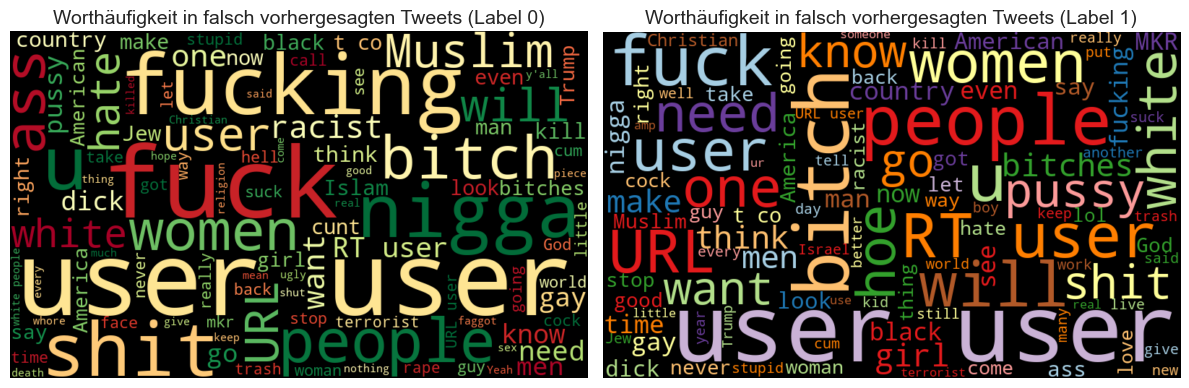

In [457]:
print_wordcloud(mostly_false_merged_tweet_cleaned1, tweet_col="tweet", label_col="label")

#### 4.4 Mixed-Test cleaned - Schwellwert 0.35

In [ ]:
merged_false_tweet_cleaned2 = create_false_tweet_df(tweet_col="tweet_cleaned", label_col="label", original_df=df_mixed_test_cleaned,
                                                    threshold=0.35)

In [ ]:
merged_false_tweet_cleaned2

In [ ]:
all_false_merged_tweet_cleaned2 = get_all_false_merged(merged_false_tweet_cleaned2, label_col="label")
all_false_merged_tweet_cleaned2

In [ ]:
mostly_false_merged_tweet_cleaned2 = get_mostly_false_merged(merged_false_tweet_cleaned2, label_col="label")
mostly_false_merged_tweet_cleaned2

In [ ]:
print_wordcloud(mostly_false_merged_tweet_cleaned2, tweet_col="tweet", label_col="label")